# Transfer Learning

*Author: Charles (Charlie) Rice for Break Through Tech*

---

In general, adult humans do not learn new things totally from scratch. Consider a landscape painter creating a portrait for a new show. They have never painted a portrait before, but have been painting for a long time. They know how to blend colors, how to use perspective, and how to capture texture, among other skills. The painter is able to transfer their existing skills to the new task.

We can do something similar with deep learning and take a model trained on one task and refine it into a model for a different, but related, task. We do this primarily when the resources for creating a wholly new model - a large labeled dataset and significant computing resources, for example - are not available or are impractical. This process is called **transfer learning.**

In this lesson, we will cover some of the basics of transfer learning using the Keras framework of Tensorflow.

# Learning Objectives
By the end of this lesson, you will be able to:
1.   Describe the use case for transfer learning
2.   Implement a transfer learning workflow in Keras

# Acknowledgments
This demonstration is adapted from Francois Chollet's "[Transfer Learning & Fine Tuning](https://keras.io/guides/transfer_learning/)" tutorial from the Keras documentation.



# Recap of Neural Networks
Neural networks and deep learning have revolutionized machine learning. They are immensely powerful tools for understanding data and building predictive models. Let's take a look at a stylized image of a neural network.

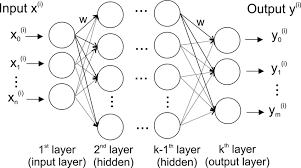  
Image Credit: Rammer, Werner & Seidl, Rupert. (2019). [Harnessing Deep Learning in Ecology: An Example Predicting Bark Beetle Outbreaks](https://www.researchgate.net/figure/Stylized-structure-of-a-deep-feedforward-neural-network-Each-of-the-k-layers-consists-of_fig1_336858906). Frontiers in Plant Science. 10. 1327. 10.3389/fpls.2019.01327.

In the image above we see an input layer on the left (`Input x`), an output layer on the right (`Output y`) and an arbitrary number (represented by `...` )of hidden layers in between. Each circle represents a node of the network, where some calculation happens. The vertical lines of circles represents one layer of the network. Each line connecting the circles (called an "edge" in network terminology) represents some weight. These weights feed into the calculations in the nodes, and are updated with each pass of the data through the neural network. It is, essentially, the weights and layers that are storing what the network learns over time. And it is the weights that concern us in transfer learning. (Other learning too: they're similar in function to the betas of a simple linear regression, really: they tell the network how important something is. They just aren't human interpretable the way βs are.)

The weights and layers represent the model, the learning that has been done on other data. In transfer learning, we take the weights and layers from a trained model and fine-tune them to a new, but similar or related task.  We might take a model trained on the time series of one stock's price and fine tune it with another. Or we might take a model trained on images of horses and donkeys, and teach it to recognize zebras as well.

Aside: If you have followed the news and discussions around the Large Language Models (LLMs) and open-sourcing, they are talking about publishing the full weights and biases so that researchers can study how and what things like ChatGPT are learning.

# Necessary Imports

In [ ]:
import numpy as np
import keras
from keras import layers
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt

# The `trainable` Attribute
It may surprise you to learn that the `layers` in Keras actually have attributes that we can access. They're part of how Keras builds and runs neural networks under the hood.

Let's instantiate a very small, untrained model just to show them off:

In [ ]:
layer = keras.layers.Dense(3)
layer.build((None, 4))  # Create the weights

print("weights:", len(layer.weights))
print("trainable_weights:", len(layer.trainable_weights))
print("non_trainable_weights:", len(layer.non_trainable_weights))

weights: 2
trainable_weights: 2
non_trainable_weights: 0


* `weights` is all of the weight variables in that particular layer.
* `trainable_weights` is the set of weights that can be updated during the training process, usually via gradient descent
* `non_trainable_weights` are the weights that aren't meant to be updated.

For the most part, all weights are trainable weights. There's only one built-in keras layer that uses `non_trainable_weights` - the `BatchNormalization` layer, which uses them keep track of the mean and variance of inputs during training.

In [ ]:
layer = keras.layers.BatchNormalization()
layer.build((None, 4))  # Create the weights

print("weights:", len(layer.weights))
print("trainable_weights:", len(layer.trainable_weights))
print("non_trainable_weights:", len(layer.non_trainable_weights))

weights: 4
trainable_weights: 2
non_trainable_weights: 2


We have the option to set any layer we want to as `non_trainable` by setting the `trainable` attribute of `layer` to `False`. It's a boolean attribute and will change the trainability of all weights in that layer. We call this "freezing" the layer - it will no longer update. It's this attribute we use in the transfer learning workflow.

# Transfer Learning Workflows
There are actually two workflows for transfer learning in Keras. One (the standard workflow) is as follows:


1.   Instantiate a base model and load pre-trained weights into it.  
2. Freeze all layers in the base model by setting `trainable = False.`
3. Create a new model on top of the output of one (or several) layers from the base model.
4. Train your new model on your new dataset.

Let's model that workflow.



## Get the Data
First, we need to get some data. We're going to use the cats vs dogs dataset that's actually built into TensorFlow. We're also going to reduce the size of the dataset, since transfer learning tends to be used on very small datasets.

In [ ]:
tfds.disable_progress_bar()

train_ds, validation_ds, test_ds = tfds.load(
    "cats_vs_dogs",
    # Reserve 10% for validation and 10% for test
    split=["train[:20%]", "train[20%:30%]", "train[30%:40%]"],
    as_supervised=True,  # Include labels
)

print(f"Number of training samples: {train_ds.cardinality()}")
print(f"Number of validation samples: {validation_ds.cardinality()}")
print(f"Number of test samples: {test_ds.cardinality()}")

Dataset cats_vs_dogs downloaded and prepared to /root/tensorflow_datasets/cats_vs_dogs/4.0.1. Subsequent calls will reuse this data.
Number of training samples: 4652
Number of validation samples: 2327
Number of test samples: 2326


Let's take a look at some of our images. One thing to note: they are all different sizes. They will need to be standardized for learning. Also, 0 appears to be the label for Cat; 1 for Dog.

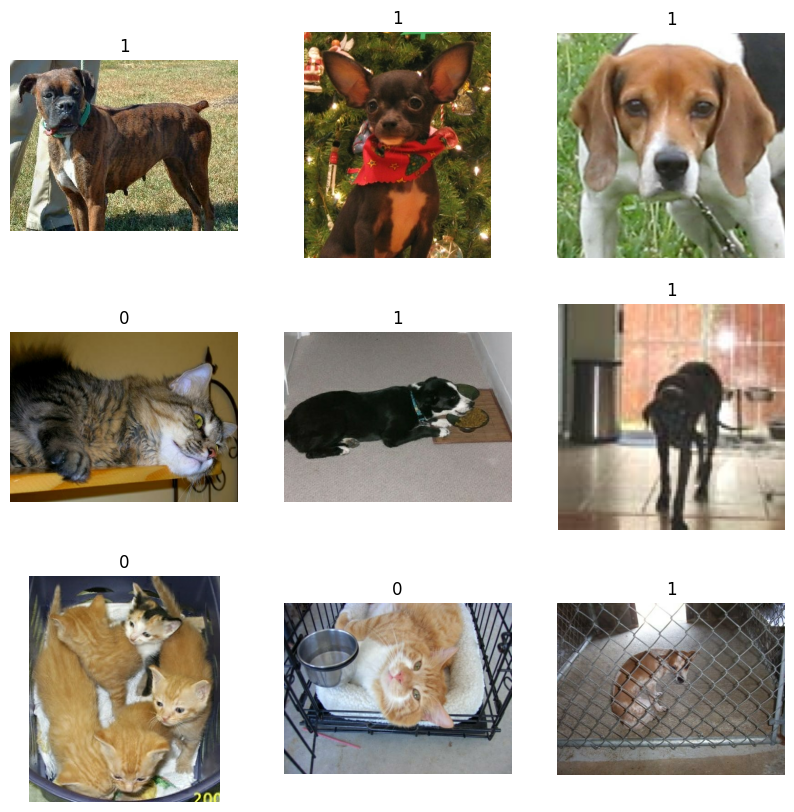

In [ ]:
plt.figure(figsize=(10, 10))
for i, (image, label) in enumerate(train_ds.take(9)):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image)
    plt.title(int(label))
    plt.axis("off")

When working with image data - really data of any kind - we should assume that the input data is going to be messy (different sizes, too many colors, &c) and build in pre-processing to our pipelines. This will minimize the headaches you might have should you need to export the model to, for example, a web application. That's what we're doing in the cell below:

In [ ]:
# Resize images to (150,150)
resize_fn = keras.layers.Resizing(150, 150)

train_ds = train_ds.map(lambda x, y: (resize_fn(x), y))
validation_ds = validation_ds.map(lambda x, y: (resize_fn(x), y))
test_ds = test_ds.map(lambda x, y: (resize_fn(x), y))

In [ ]:
train_ds

<_MapDataset element_spec=(TensorSpec(shape=(150, 150, 3), dtype=tf.float32, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

# Data Augmentation
Recall that transfer learning tends to be most effective (or at least used most often) on datasets that are smaller than we would like for purposes of training. That doesn't mean we shouldn't use the data we have, however.

We're going to add in some augmentation and expand our dataset just a shade. This has the added advantage of reducing overfitting in training.

In [ ]:
augmentation_layers = [
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
]


def data_augmentation(x):
    for layer in augmentation_layers:
        x = layer(x)
    return x


train_ds = train_ds.map(lambda x, y: (data_augmentation(x), y))

In order to help expedite training, we're going to batch the data and prefetch it. Prefetching is a built-in process that collects the next batch of data while simultaneously training the current batch. This helps to eliminate processing bottlenecks.

In [ ]:
from tensorflow import data as tf_data  # Import TensorFlow's data module for data pipeline operations.

batch_size = 64  # Define the batch size for training, validation, and testing datasets.

# Prepare the training dataset:
train_ds = (
    train_ds
    .batch(batch_size)  # Group the dataset into batches of size `batch_size` (64 here).
    .prefetch(tf_data.AUTOTUNE)  # Fetch the next batch of data asynchronously while the current batch is being processed.
    .cache()  # Cache the dataset in memory or disk to improve performance during training.
)

# Prepare the validation dataset:
validation_ds = (
    validation_ds
    .batch(batch_size)  # Group the validation dataset into batches of size `batch_size`.
    .prefetch(tf_data.AUTOTUNE)  # Asynchronously prefetch data for faster evaluation during validation steps.
    .cache()  # Cache the dataset to avoid redundant computations or file reads during validation.
)

# Prepare the test dataset:
test_ds = (
    test_ds
    .batch(batch_size)  # Group the test dataset into batches of size `batch_size`.
    .prefetch(tf_data.AUTOTUNE)  # Prefetch data asynchronously to ensure smoother processing.
    .cache()  # Cache the dataset to avoid redundant computations or disk reads during testing.
)

Because we are responsible data scientists, we should take a look at the augmented images we have created:

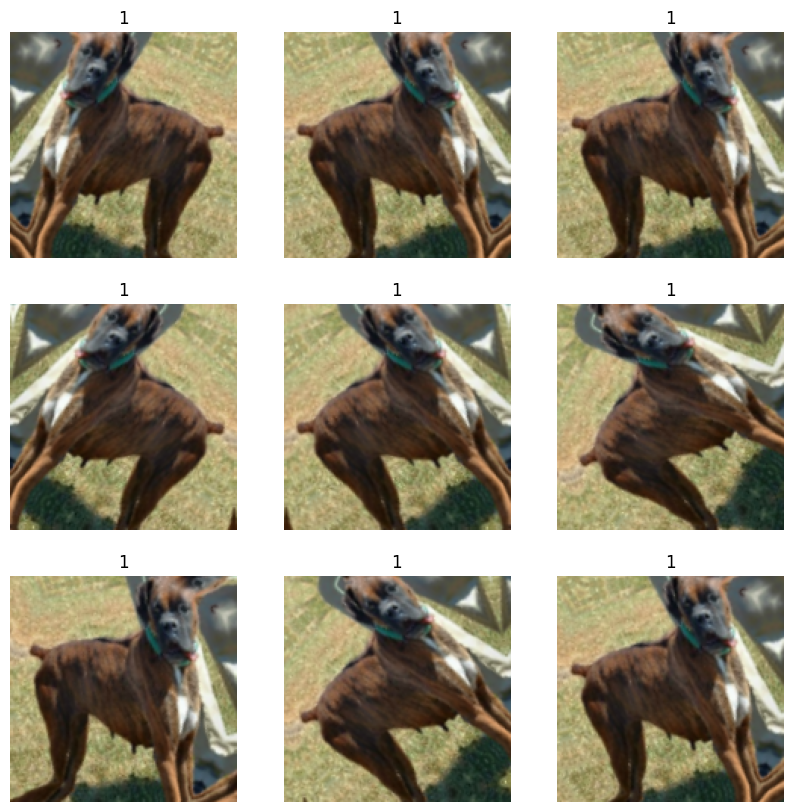

In [ ]:
for images, labels in train_ds.take(1):
    plt.figure(figsize=(10, 10))
    first_image = images[0]
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        augmented_image = data_augmentation(np.expand_dims(first_image, 0))
        plt.imshow(np.array(augmented_image[0]).astype("int32"))
        plt.title(int(labels[0]))
        plt.axis("off")

And now we build the model. This process looks different than other neural network processe we've used, so it requires some explanation.

First, we take in a base model. In this case, we are using the Xception architecture (the arrangement of layers for the Xception model) and weights pre-trained on the ImageNet database. We are feeding it the shape of our data (150x150x3) but we are also telling it to ignore the first three densely-connected layers of the Xception model. Using this would be the same as just using the Xception model, and no transfer would take place.

We set `base_model.trainable` to `False`. This means that the base model will run in inference mode and NOT learn new weights from new data, even when we unfreeze it later for fine-tuning.

We add in a rescaling layer to scale our color pixels from [0,255] to [-1,1] because that's what neural networks like.

And finally we add in a Dropout layer to help with regularization.

In [ ]:
# Load the pre-trained Xception model as the base model for transfer learning
base_model = keras.applications.Xception(
    weights="imagenet",  # Use weights pre-trained on the ImageNet dataset.
    input_shape=(150, 150, 3),  # Define the input shape expected by the base model (150x150 RGB images).
    include_top=False,  # Exclude the fully connected classifier layers at the top (we will add our own).
)

# Freeze the base model's layers to prevent them from being updated during training.
base_model.trainable = False

# Define the input for the new model
inputs = keras.Input(shape=(150, 150, 3))  # Create an input layer for images with size 150x150 and 3 color channels (RGB).

# Add a rescaling layer to preprocess the input images.
# Pre-trained Xception requires input values to be scaled from (0, 255) to (-1, 1).
scale_layer = keras.layers.Rescaling(scale=1 / 127.5, offset=-1)  # Rescale pixel values to the required range.
x = scale_layer(inputs)  # Apply the rescaling transformation to the input.

# Pass the rescaled input through the base model.
# `training=False` ensures that the base model's batch normalization layers remain in inference mode,
# even if the overall model is being trained.
x = base_model(x, training=False)

# Apply global average pooling to reduce the spatial dimensions of the feature maps.
# This aggregates the spatial information into a single vector per feature map.
x = keras.layers.GlobalAveragePooling2D()(x)

# Add a dropout layer to prevent overfitting by randomly setting 20% of the input units to zero during training.
x = keras.layers.Dropout(0.2)(x)

# Add a dense (fully connected) output layer with 1 unit.
# This layer produces the final prediction output of the model.
outputs = keras.layers.Dense(1)(x)

# Create the complete model by connecting the inputs to the outputs.
model = keras.Model(inputs, outputs)

# Display the model's architecture, including which layers are trainable and which are frozen.
model.summary(show_trainable=True)

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━┓
┃ Layer (type)                        ┃ Output Shape                 ┃       Param # ┃ Traina… ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━┩
│ input_layer_3 (InputLayer)          │ (None, 150, 150, 3)          │             0 │    -    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ rescaling_1 (Rescaling)             │ (None, 150, 150, 3)          │             0 │    -    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ xception (Functional)               │ (None, 5, 5, 2048)           │    20,861,480 │    N    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ global_average_pooling2d_1          │ (None, 2048)                 │             0 │    -    │
│ (GlobalAveragePooling2D)            │                              │               │         │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ dropout_1 (Dropout)                 │ (None, 2048)                 │             0 │    -    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ dense_2 (Dense)                     │ (None, 1)                    │         2,049 │    Y    │
└─────────────────────────────────────┴──────────────────────────────┴───────────────┴─────────┘

 Total params: 20,863,529 (79.59 MB)

 Trainable params: 2,049 (8.00 KB)

 Non-trainable params: 20,861,480 (79.58 MB)

Now that we have a model, we're going to only train the top layer.

In [ ]:
model.compile(
    optimizer=keras.optimizers.Adam(),
    loss=keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=[keras.metrics.BinaryAccuracy()],
)

epochs = 2
print("Fitting the top layer of the model")
model.fit(train_ds, epochs=epochs, validation_data=validation_ds)

Fitting the top layer of the model
Epoch 1/2
73/73 ━━━━━━━━━━━━━━━━━━━━ 777s 11s/step - binary_accuracy: 0.7991 - loss: 0.4006 - val_binary_accuracy: 0.9639 - val_loss: 0.1018
Epoch 2/2
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - binary_accuracy: 0.9288 - loss: 0.1698

And straight out of the box we get a darn good binary accuracy rate, and a pretty low validation loss, without a heavy duty training round.

# Fine Tuning
The final step, which may be optional in many use cases, is fine tuning. This is where we will unfreeze the base model and train the entire model with a low (less than 0.01) learning rate. It should be pointed out, though, that although we are going to change `base_model.trainable` to `True` the model remains in inference mode because, when building the model, the call to `base_model` set `training` to `False.` This keeps the batchnorm layer from updating weights, which would destroy what was learned by the Xception model and ImageNet.

**NOTE**: Given the low learning rate, the cell below will take close to 40 minutes to run in Colab. It *may* exhaust the system resources.

In [ ]:
# Unfreeze the base_model. Note that it keeps running in inference mode
# since we passed `training=False` when calling it. This means that
# the batchnorm layers will not update their batch statistics.
# This prevents the batchnorm layers from undoing all the training
# we've done so far.
base_model.trainable = True
model.summary(show_trainable=True)

model.compile(
    optimizer=keras.optimizers.Adam(1e-5),  # Low learning rate
    loss=keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=[keras.metrics.BinaryAccuracy()],
)

epochs = 1
print("Fitting the end-to-end model")
model.fit(train_ds, epochs=epochs, validation_data=validation_ds)

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━┓
┃ Layer (type)                        ┃ Output Shape                 ┃       Param # ┃ Traina… ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━┩
│ input_layer_3 (InputLayer)          │ (None, 150, 150, 3)          │             0 │    -    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ rescaling_1 (Rescaling)             │ (None, 150, 150, 3)          │             0 │    -    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ xception (Functional)               │ (None, 5, 5, 2048)           │    20,861,480 │    Y    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ global_average_pooling2d_1          │ (None, 2048)                 │             0 │    -    │
│ (GlobalAveragePooling2D)            │                              │               │         │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ dropout_1 (Dropout)                 │ (None, 2048)                 │             0 │    -    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ dense_2 (Dense)                     │ (None, 1)                    │         2,049 │    Y    │
└─────────────────────────────────────┴──────────────────────────────┴───────────────┴─────────┘

 Total params: 20,867,629 (79.60 MB)

 Trainable params: 20,809,001 (79.38 MB)

 Non-trainable params: 54,528 (213.00 KB)

 Optimizer params: 4,100 (16.02 KB)

Fitting the end-to-end model
73/73 ━━━━━━━━━━━━━━━━━━━━ 2231s 30s/step - binary_accuracy: 0.8202 - loss: 0.4405 - val_binary_accuracy: 0.9639 - val_loss: 0.1056


Given the system limitations of Colab, the cell above may exhaust available resources. It does, however, eke out a few more points of accuracy over the base model.

# Conclusion

In this demonstration, we have shown what transfer learning is, when to use it, and how to implement a standard workflow. This is not the only way of doing transfer learning, however, and it is specifically built for image classification. As you may have already found, just about every topic in machine learning rewards further research and transfer learning is no exception.